# Ch 4. 신경망 학습

---

2024.08.03.

기준: 기존에 아는 내용은 스킵하고, 복습할 내용만 정리한다.

## 4.1 데이터에서 학습한다!

### 4.1.1 데이터 주도 학습

- 기계학습은 데이터가 생명이다. 
- 데이터에서 답을 찾고 데이터에서 패턴을 발견하고 데이터로 이야기를 만드는 것이다.
- 사람의 개입을 최소화하고, 수집한 데이터로부터 패턴을 찾으려 시도한다.
- 이미지에서 `특징(feature)`을 추출하고 그 특징의 패턴을 기계학습 기술로 학습하는 방법이 있다.
- 다만, 이미지를 벡터로 변환할 때 사용하는 특징은 여전히 사람이 설계하는 것임에 주의하라.


### 4.1.2 훈련 데이터와 시험 데이터

- 기계학습 문제는 데이터를 `훈련 데이터(training data)`와 `시험 데이터(test data)`로 나눠 학습과 실험을 수행하는 것이 일반적이다.
- 우선 훈련 데이터만 사용하여 학습하면서 최적의 매개변수를 찾는다.
- 그런 다음 시험 데이터를 사용하여 앞서 훈련한 모델의 실력을 평가한다.
- 이를 `범용 능력(일반화 능력)`을 평가한다고 한다.
- 참고로 한 데이터셋에만 지나치게 최적화된 상태를 `오버피팅(과적합, overfitting)`이라고 한다.

### 4.2 손실 함수(loss function)

- 신경망 학습에서는 `하나의 지표`를 기준으로 최적의 매개변수 값을 탐색한다.
- 그리고 그 지표를 가장 좋게 만들어주는 가중치 매개변수의 값을 탐색하는 것이다.
- 이 지표를 `손실 함수(loss function)`이라고 한다.

#### 4.2.1 오차제곱합

- 가장 많이 쓰이는 손실 함수

$$ E = \frac{1}{2} \sum_{k} (y_k - t_k)^2 $$

- $y_k$는 신경망의 출력, $t_k$는 정답 레이블, $k$는 데이터 차원 수

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [211]:
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [212]:
def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [213]:
sum_squares_error(np.array(y), np.array(t))

0.09750000000000003

In [214]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

In [215]:
sum_squares_error(np.array(y), np.array(t))

0.5975

#### 4.2.2 교차 엔트로피 오차

$$ E = - \sum_{k} t_k \log y_k $$

- $t_k$는 정답 레이블, $y_k$는 신경망의 출력

In [216]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

- 여기서 델타 값을 더하는 이유는 np.log() 함수에 0을 입력하면 마이너스 무한대가 되어 더 이상 계산을 진행할 수 없기 때문이다.
- 즉, 아주 작은 값을 더해주어 0이 되지 않도록 한다.

In [217]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

In [218]:
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [219]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

In [220]:
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

#### 4.2.3 미니배치 학습

- 훈련 데이터 모두에 대한 손실 함수의 합을 구하는 방법이 필요함
- 데이터가 많을 때는 모든 데이터에 대한 손실 함수를 계산하는 것은 현실적이지 않음
- 데이터 일부를 추려 전체의 근사치로 이용
- 이를 `미니배치(mini-batch)` 학습이라 함

$$ E = - \frac{1}{N} \sum_{n} \sum_{k} t_{nk} \log y_{nk} $$

- $N$은 데이터의 개수, $t_{nk}$는 $n$번째 데이터의 $k$번째 값을 의미

In [221]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [222]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [223]:
np.random.choice(60000, 10)

array([35390, 21837, 48931, 22046, 32333, 18383, 28400, 48682,  4365,
       11160])

#### 4.2.4 (배치용) 교차 엔트로피 오차 구현하기

In [224]:
def cross_entropy_error1(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [225]:
def cross_entropy_error2(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### 4.2.5 왜 손실 함수를 설정하는가?

- 신경망 학습에서의 '미분'의 역할에 주목한다면 해결된다.
- 신경망 학습에서는 최적의 매개변수(가중치와 편향)을 탐색할 때 손실 함수의 값을 가능한 작게 하는 매개변수 값을 찾는다.
- 이때 매개변수의 미분(정확히는 기울기)을 계산하고, 그 미분 값을 단서로 매개변수의 값을 서서히 갱신하는 과정을 반복한다.
- 정확도를 지표로 삼으면 매개변수의 미분이 대부분의 장소에서 0이 되어 매개변수를 갱신할 수 없다.

> 신경망을 학습할 때 정확도를 지표로 삼아서는 안 된다. 정확도를 지표로 하면 매개변수의 미분이 대부분의 장소에서 0이 되기 때문이다. 정확도는 매개변수의 미소한 변화에는 거의 반응을 보이지 않다가, 불연속적으로 갑자기 변화한다.

### 4.3 수치 미분

#### 4.3.1 미분

- 미분: 한순간의 변화량
- 수치 미분: 아주 작은 차분으로 미분하는 것
- 해석적 미분: 수식을 전개해 미분하는 것

$$ \frac{df(x)}{dx} = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h} $$

- 해당 식은 좌변 f(x)의 x에 대한 미분을 나타낸다.
- 즉, x의 작은 변화가 함수 f(x)를 얼마나 변화시키느냐를 의미한다.

In [2]:
def numerical_diff_bad(f, x):
    h = 1e-50
    return (f(x+h) - f(x)) / h

In [3]:
np.float32(1e-50)

0.0

In [228]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

#### 4.3.2 수치 미분의 예

$$ y = 0.01x^2 + 0.1x $$

- 이 함수의 해석적 미분은 $0.02x + 0.1$

In [229]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

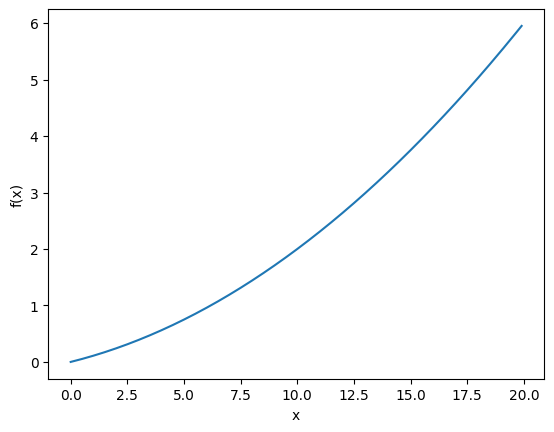

In [230]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [231]:
numerical_diff(function_1, 5)

0.1999999999990898

In [232]:
numerical_diff(function_1, 10)

0.2999999999986347

- 해석적 해
$$ \frac{df(x)}{dx} = 0.02x + 0.1 $$

#### 4.3.3 편미분

- 변수가 여럿인 함수에 대한 미분을 `편미분`이라 한다.

In [233]:
def function_2(x):
    return x[0]**2 + x[1]**2

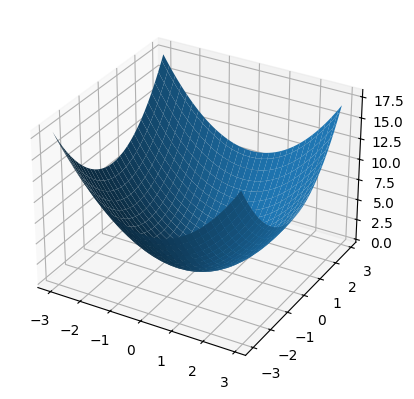

In [234]:
x0 = np.arange(-3, 3, 0.1)
x1 = np.arange(-3, 3, 0.1)
X, Y = np.meshgrid(x0, x1)
Z = function_2(np.array([X, Y]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()

문제1 : $x_0 = 3, x_1 = 4$일 때 $x_0$에 대한 편미분

In [235]:
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

In [236]:
numerical_diff(function_tmp1, 3.0)

6.00000000000378

문제2 : $x_0 = 3, x_1 = 4$일 때 $x_1$에 대한 편미분

In [237]:
def function_tmp2(x1):
    return 3.0**2.0 + x1*x1

In [238]:
numerical_diff(function_tmp2, 4.0)

7.999999999999119

### 4.4 기울기

$$ \left( \frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1} \right) $$

- 모든 변수의 편미분을 벡터로 정리한 것을 `기울기(gradient)`라고 한다.

In [239]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    
    return grad

In [240]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [241]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [242]:
numerical_gradient(function_2, np.array([3.0, 0.0]))

array([6., 0.])

#### 4.4.1 경사법(경사 하강법)

- 기울기를 이용해 함수의 최솟값을 찾으려는 방법
- 기울기가 가리키는 곳에 함수의 최솟값이 있다고 가정하고, 기울기가 가리키는 방향으로 일정 거리만큼 이동하고, 이 과정을 반복한다.
$$ x_0 = x_0 - \eta \frac{\partial f}{\partial x_0} $$
$$ x_1 = x_1 - \eta \frac{\partial f}{\partial x_1} $$
- 학습률(learning rate)는 한 번의 학습으로 얼마만큼 학습해야 할지, 즉 매개변수 값을 얼마나 갱신할지를 정하는 것이다.

In [243]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    
    return x

- 인수 f: 최적화하려는 함수
- init_x: 초깃값
- lr: 학습률
- step_num: 경사법에 따른 반복 횟수

문제 : $f(x_0, x_1) = x_0^2 + x_1^2$의 최솟값 구하기

In [244]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

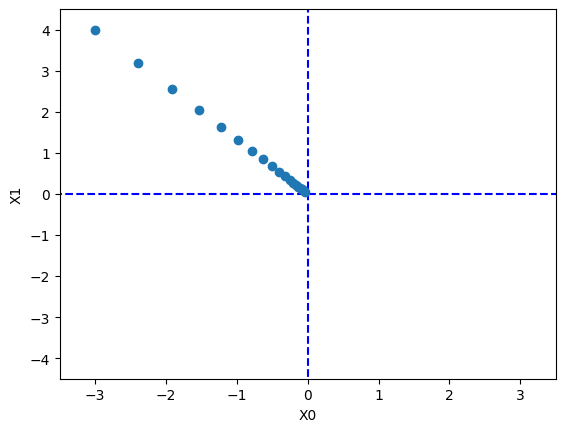

In [245]:
def gradient_descent_graph(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

init_x = np.array([-3.0, 4.0])
lr = 0.1
step_num = 20
x, x_history = gradient_descent_graph(function_2, init_x, lr=lr, step_num=step_num)

plt.plot([-5, 5], [0, 0], '--b')
plt.plot([0, 0], [-5, 5], '--b')
plt.plot(x_history[:, 0], x_history[:, 1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

- 학습률이 너무 큰 경우

In [246]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100)

array([-2.58983747e+13, -1.29524862e+12])

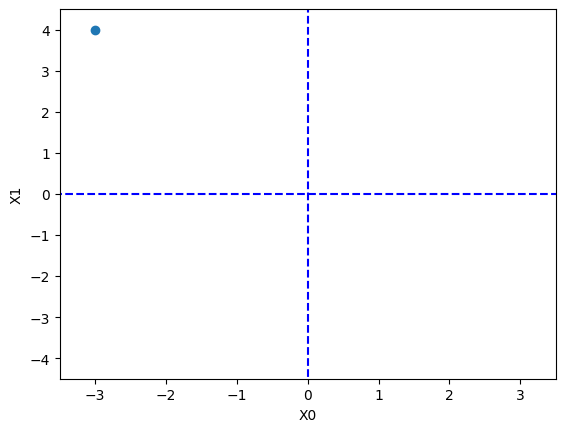

In [247]:
init_x = np.array([-3.0, 4.0])
lr = 10.0
step_num = 20
x, x_history = gradient_descent_graph(function_2, init_x, lr=lr, step_num=step_num)

plt.plot([-5, 5], [0, 0], '--b')
plt.plot([0, 0], [-5, 5], '--b')
plt.plot(x_history[:, 0], x_history[:, 1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

- 학습률이 너무 작은 경우


In [248]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100)

array([-2.99999994,  3.99999992])

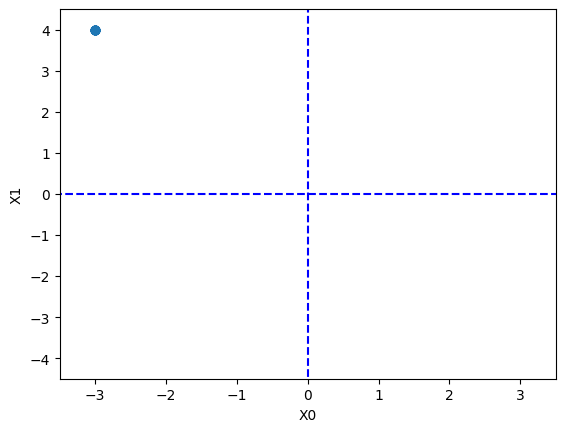

In [249]:
init_x = np.array([-3.0, 4.0])
lr = 1e-10
step_num = 20
x, x_history = gradient_descent_graph(function_2, init_x, lr=lr, step_num=step_num)

plt.plot([-5, 5], [0, 0], '--b')
plt.plot([0, 0], [-5, 5], '--b')
plt.plot(x_history[:, 0], x_history[:, 1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

### 4.4.2 신경망에서의 기울기

- 신경망에서의 기울기 = 가중치 매개변수에 대한 손실 함수의 기울기
- 가중치 매개변수에 대한 손실 함수의 기울기를 구하고, 그 결과를 토대로 가중치 매개변수를 갱신하는 것이다.

In [250]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

In [251]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [252]:
net = simpleNet()

In [253]:
print(net.W) # 가중치 매개변수

[[-1.18034637 -0.16635392 -0.51153646]
 [ 0.15122311 -1.52007685  0.03171987]]


In [254]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p) # 예측값

[-0.57210702 -1.46788151 -0.27837399]


In [255]:
np.argmax(p) # 최댓값의 인덱스

2

In [256]:
t = np.array([0, 0, 1]) # 정답 레이블
net.loss(x, t)

0.717764759079433

In [257]:
def f(W):
    return net.loss(x, t)

In [258]:
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.21820423  0.08909088 -0.30729511]
 [ 0.32730634  0.13363632 -0.46094266]]


In [259]:
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

In [260]:
print(dW)

[[ 0.21820423  0.08909088 -0.30729511]
 [ 0.32730634  0.13363632 -0.46094266]]


### 4.5 학습 알고리즘 구현하기

신경망 학습의 절차
- 전제
    - 신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 함
- 1단계 미니배치
    - 훈련 데이터 중 일부를 무작위로 가져옴
- 2단계 기울기 산출
    - 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구함
- 3단계 매개변수 갱신
    - 가중치 매개변수를 기울기 방향으로 아주 조금 갱신
- 반복
    - 1~3단계를 반복

#### 4.5.1 2층 신경망 클래스 구현하기

In [261]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import *
from common.gradient import numerical_gradient

In [262]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
                
        return grads

In [263]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

In [264]:
net.params['W1'].shape

(784, 100)

In [265]:
net.params['b1'].shape

(100,)

In [266]:
net.params['W2'].shape

(100, 10)

In [267]:
net.params['b2'].shape

(10,)

In [268]:
x = np.random.rand(100, 784)
y = net.predict(x)

In [269]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

In [270]:
grads = net.numerical_gradient(x, t)

In [271]:
grads['W1'].shape

(784, 100)

In [272]:
grads['b1'].shape

(100,)

In [273]:
grads['W2'].shape

(100, 10)

In [274]:
grads['b2'].shape

(10,)

#### 4.5.2 미니배치 학습 구현하기

In [275]:
from dataset.mnist import load_mnist
from tqdm import trange, notebook

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

In [276]:
iters_num = 100
train_size = x_train.shape[0]
batch_size = 10
learning_rate = 0.1
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [277]:
for i in notebook.tqdm(range(iters_num)):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

  0%|          | 0/100 [00:00<?, ?it/s]

In [278]:
len(train_loss_list)

100

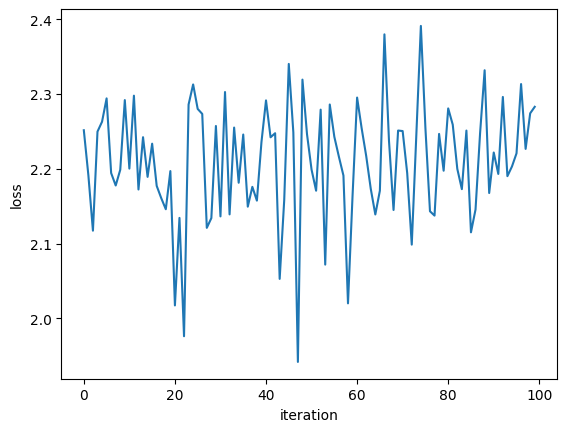

In [279]:
# 그래프 그리기
import matplotlib.pyplot as plt

x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

#### 4.5.3 시험 데이터로 평가하기

In [280]:
# (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
# 
# network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
# 
# train_loss_list = []
# train_acc_list = []
# test_acc_list = []
# 
# # 하나의 에폭당 반복 수
# iter_per_epoch = max(train_size / batch_size, 1)

In [281]:
# iters_num = 100
# train_size = x_train.shape[0]
# batch_size = 10
# learning_rate = 0.1

In [ ]:
# for i in notebook.tqdm(range(iters_num)):
#     # 미니배치 획득
#     batch_mask = np.random.choice(train_size, batch_size)
#     x_batch = x_train[batch_mask]
#     t_batch = t_train[batch_mask]
#     
#     # 기울기 계산
#     grad = network.numerical_gradient(x_batch, t_batch)
#     
#     # 매개변수 갱신
#     for key in ('W1', 'b1', 'W2', 'b2'):
#         network.params[key] -= learning_rate * grad[key]
#     
#     # 학습 경과 기록
#     loss = network.loss(x_batch, t_batch)
#     train_loss_list.append(loss)
#     
#     # 1 에폭당 정확도 계산
#     if i % iter_per_epoch == 0:
#         train_acc = network.accuracy(x_train, t_train)
#         test_acc = network.accuracy(x_test, t_test)
#         train_acc_list.append(train_acc)
#         test_acc_list.append(test_acc)
#         print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

  0%|          | 0/100 [00:00<?, ?it/s]

train acc, test acc | 0.09035, 0.0892


In [ ]:
# len(train_acc_list)

In [ ]:
# 그래프 그리기
# x = np.arange(len(train_acc_list))
# plt.plot(x, train_acc_list, label='train acc')
# plt.plot(x, test_acc_list, label='test acc', linestyle='--')
# plt.xlabel("epochs")
# plt.ylabel("accuracy")
# plt.legend(loc='lower right')
# plt.show()